In [103]:
library(tidyr)
library("pxweb")
library("tidyverse")
library("GGally")
library("ggpubr")



Warning message:
"package 'pxweb' is in use and will not be installed"


We are going to explore if it is reasonable to use a MLR model to predict the number of people graduating from three different levels of education. 
We will also explore if the model performs better for the entire population or for men and women separately.

In [104]:
#d <- pxweb_interactive("https://api.scb.se/OV0104/v1/doris/sv/ssd/UF/UF0550/UF0550C/Historisk11bN")
API_wait<-1e-3
pxq_edu <-
  list(
    "Examen" = c("*"), # Use "*" to select all
    "Kon" = c("*"),
    "ContentsCode" = c("000004NE"),
    "Tid" = c("*")
  )
pxg_edu<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN",pxq_edu)
Sys.sleep(API_wait)
pxq_pop <-
  list(
    "Kon" = c("*"),
    "ContentsCode" = c("000000LV"),
    "Tid" = c("*")
  )

pxg_pop<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/BefUtvKon1749",pxq_pop)
Sys.sleep(API_wait)
#https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28
pxq_income<-list(

  "Kon" = c("*"),
  "Tid" = c("*"),
  "ContentsCode" = c("HE0103CL")
          #"HE0103CM")
)
pxg_income<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28",pxq_income)

Sys.sleep(API_wait)
pxq_kpi<-list(
  "Tid" = c("*"),
  "ContentsCode" = c("000004VU")#,
          #"000004VT")
)
pxg_kpi<-pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM",pxq_kpi)

We start by gathering data from SCB about education,income,KPI and population.
Then we clean and modify the data to fit our needs.

In [ ]:
edu_df<-as.data.frame(pxg_edu)
edu_df<-as_tibble(edu_df)

doktor_df<-edu_df%>%
filter(examen%in%c("Doktorsgrad","Doktorsexamen"))%>%
group_by(läsår,kön)%>%
mutate(`Utfärdade examina vid universitet och högskolor`=sum(`Utfärdade examina vid universitet och högskolor`))%>%
filter(examen=="Doktorsexamen")%>%
ungroup()


licenciat_df<-edu_df%>%
filter(examen%in%c("Licentiatexamen","Licentiatexamen (Äldre)"))%>%
group_by(läsår,kön)%>%
mutate(`Utfärdade examina vid universitet och högskolor`=sum(`Utfärdade examina vid universitet och högskolor`))%>%
filter(examen=="Licentiatexamen")%>%
ungroup()


edu_df<-edu_df%>%
filter(examen=="Examen från grundutbildning")%>%
full_join(licenciat_df)%>%
full_join(doktor_df)%>%
pivot_wider(names_from=kön,values_from = `Utfärdade examina vid universitet och högskolor`)%>%
mutate(läsår=as.integer(str_extract(läsår,"^\\w*")))%>%rename(år=läsår)%>%
pivot_longer(!c(år,examen),names_to = "kön",values_to = "antal")%>%
mutate(kön=str_replace(kön,"båda könen","totalt"),
    examen=factor(examen,
    ordered = FALSE,
    levels = c(
    "Examen från grundutbildning","Licentiatexamen","Licentiatexamen (Äldre)","Doktorsgrad","Doktorsexamen"
    ),
    labels=c(
        "Grundutbildning","Licentiatexamen","Licentiatexamen","Doktorsexamen","Doktorsexamen"
)))

pop_df<-as.data.frame(pxg_pop)
pop_df<-as_tibble(pop_df)%>%mutate(år=as.integer(år))#%>%



income_df<-as.data.frame(pxg_income)
income_df<-as_tibble(income_df)%>%filter(år>=1936)%>%mutate(år=as.integer(år))


kpi_df<-as.data.frame(pxg_kpi)
kpi_df<-as_tibble(kpi_df)%>%
mutate(månad=str_extract(månad,"(20|19)[\\d]{2}"))%>%
rename("år"="månad")%>%
group_by(år)%>%mutate(år=as.integer(år))%>%
summarize(`AVG_KPI_Fastställd` = mean(`KPI, fastställda tal`))%>%
ungroup()


final_df<-edu_df%>%
left_join(income_df,by=join_by("år",kön==kön))%>%
left_join(kpi_df,by="år")%>%
left_join(pop_df,by=join_by("år",kön==kön))%>%rename(medelinkomst=`Medelvärde, tkr`)%>%
mutate(kön=factor(kön,levels=c("totalt","kvinnor","män"),ordered = FALSE))%>% 
drop_na()

final_df%>%filter(år==1980)

Joining with `by = join_by(examen, kön, läsår, `Utfärdade examina vid
universitet och högskolor`)`
Joining with `by = join_by(examen, kön, läsår, `Utfärdade examina vid
universitet och högskolor`)`


examen,år,kön,antal,medelinkomst,AVG_KPI_Fastställd,Folkmängd
<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Grundutbildning,1980,totalt,34536,172.3,100,8317937
Grundutbildning,1980,män,12110,220.4,100,4119822
Grundutbildning,1980,kvinnor,22426,122.9,100,4198115
Licentiatexamen,1980,totalt,1,172.3,100,8317937
Licentiatexamen,1980,män,1,220.4,100,4119822
Licentiatexamen,1980,kvinnor,0,122.9,100,4198115
Doktorsexamen,1980,totalt,812,172.3,100,8317937
Doktorsexamen,1980,män,666,220.4,100,4119822
Doktorsexamen,1980,kvinnor,146,122.9,100,4198115


We then do some eploratory data analysis on the collected data

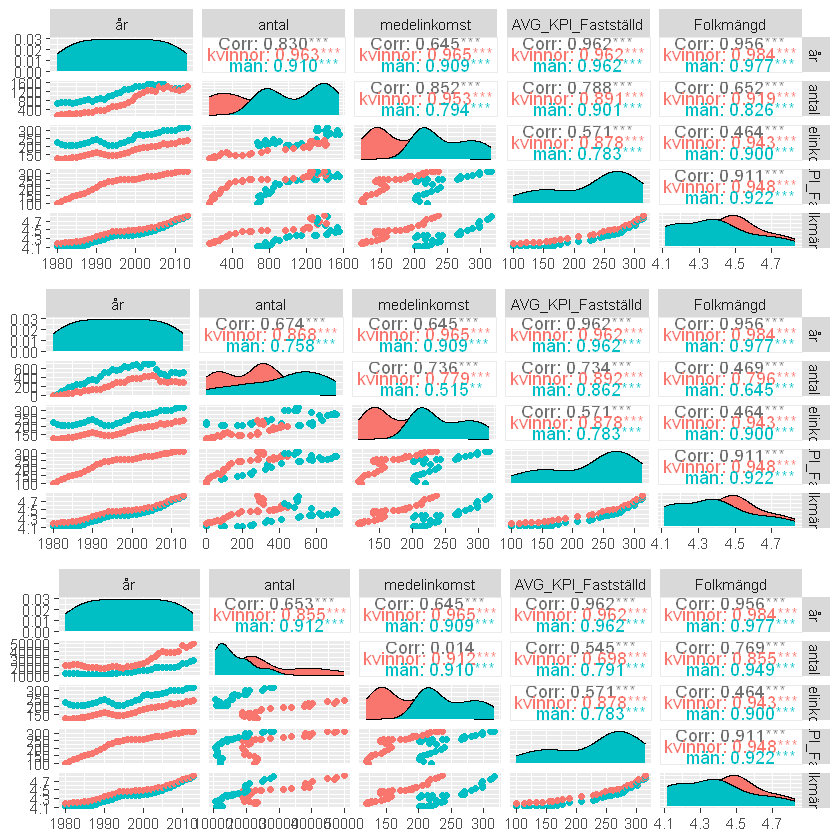

In [106]:
library(gridExtra)
library(cowplot)
dok_df<-final_df%>%
filter(examen=="Doktorsexamen",kön!="totalt")%>%
mutate(Folkmängd=1e-6*Folkmängd)

lic_df<-final_df%>%
filter(examen=="Licentiatexamen",kön!="totalt")%>%
mutate(Folkmängd=1e-6*Folkmängd)

grund_df<-final_df%>%
filter(examen=="Grundutbildning",kön!="totalt")%>%
mutate(Folkmängd=1e-6*Folkmängd)

dok_pairs<-ggpairs(data=dok_df,
columns=c("år","antal","medelinkomst","AVG_KPI_Fastställd","Folkmängd"), 
mapping=aes(color=kön))

lic_pairs<-ggpairs(data=lic_df,columns=c("år","antal","medelinkomst","AVG_KPI_Fastställd","Folkmängd"), 
mapping=aes(color=kön))

grund_pairs<-ggpairs(data=grund_df,columns=c("år","antal","medelinkomst","AVG_KPI_Fastställd","Folkmängd"),
mapping=aes(color=kön))

plot_grid(
    ggmatrix_gtable(dok_pairs), ggmatrix_gtable(lic_pairs), ggmatrix_gtable(grund_pairs),
    ncol=1)

We can see that there is some collinearity between some of the columns and that it differs between different types of degrees.

As a naive approach the first model will contain all available data in the multiple linear regression for the amount of graduates.

In [109]:
naive_model<-lm(antal~år+kön+examen+medelinkomst+Folkmängd+AVG_KPI_Fastställd,data=final_df%>%filter(kön!="totalt"))
summary(naive_model)



Call:
lm(formula = antal ~ år + kön + examen + medelinkomst + Folkmängd + 
    AVG_KPI_Fastställd, data = final_df %>% filter(kön != "totalt"))

Residuals:
    Min      1Q  Median      3Q     Max 
-7336.1 -2820.9  -343.8  2509.4 20567.5 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.674e+06  6.974e+05  -2.400  0.01733 *  
år                     8.648e+02  3.656e+02   2.365  0.01898 *  
könmän                -1.241e+03  3.123e+03  -0.397  0.69157    
examenLicentiatexamen -2.188e+04  8.268e+02 -26.464  < 2e-16 ***
examenDoktorsexamen   -2.129e+04  8.268e+02 -25.744  < 2e-16 ***
medelinkomst          -3.498e+01  3.875e+01  -0.903  0.36787    
Folkmängd             -1.050e-03  8.651e-03  -0.121  0.90357    
AVG_KPI_Fastställd    -7.788e+01  2.982e+01  -2.611  0.00972 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4821 on 196 degrees of freedom
Multiple R-squared:  0.836,	Adjusted 

In [112]:
naive_model2<-lm(antal~år+kön+examen+medelinkomst+AVG_KPI_Fastställd,data=final_df%>%filter(kön!="totalt"))
summary(naive_model2)


Call:
lm(formula = antal ~ år + kön + examen + medelinkomst + AVG_KPI_Fastställd, 
    data = final_df %>% filter(kön != "totalt"))

Residuals:
   Min     1Q Median     3Q    Max 
 -7296  -2807   -362   2527  20515 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -1.628e+06  5.878e+05  -2.770  0.00613 ** 
år                     8.397e+02  3.006e+02   2.793  0.00573 ** 
könmän                -1.184e+03  3.080e+03  -0.384  0.70108    
examenLicentiatexamen -2.188e+04  8.247e+02 -26.531  < 2e-16 ***
examenDoktorsexamen   -2.129e+04  8.247e+02 -25.809  < 2e-16 ***
medelinkomst          -3.458e+01  3.852e+01  -0.898  0.37042    
AVG_KPI_Fastställd    -7.729e+01  2.934e+01  -2.634  0.00911 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4809 on 197 degrees of freedom
Multiple R-squared:  0.8359,	Adjusted R-squared:  0.8309 
F-statistic: 167.3 on 6 and 197 DF,  p-value: < 2.2e-16


[1] "Grundutbildning" "Licentiatexamen" "Doktorsexamen"

[1] Grundutbildning Licentiatexamen Doktorsexamen  
Levels: Grundutbildning Licentiatexamen Doktorsexamen

This naive model results in a relatively high $R^2$ and $R_{adj}^{2}$ values of $R^2=0.836, R_{adj}^{2}=0.830$. The most significant regressors were the average KPI that year and if the degree was a "Licenciat" or PH. That the type of degree was significant is not at all unexpected as a Bachelor's level degree is a prerequesite for further studies. That KPI was significant could hint at the state of the economy being important in people studying or not. But the model is quite hard to interpret as a person, because of the large amount of explanatory variables. Because of this the regressor with the highest $p$-value was removed from the model, this being the population variable.

The new model had $R^2=0.836, R_{adj}^{2}=0.831$ meaning it performed slightly better than the naive model. Altough it should be noted that all of the $p$-values barely changed.

In order to increase the interpretability of the model and to more easily choose our variables, we will instead create two new models one for the amount of people graduating with a Bachelor's level degree and another for the amount of people graduating with either a "Licenciat" or PHD.

We will also aproach the problem of choosing variables in the opposite way from what was done to the naive model, that is we will add one variable at a time instead of removing them.


In [120]:

bachelor_model<-lm(antal~.,data=final_df%>%filter(examen=="Grundutbildning",kön!="totalt")%>%select(!examen))
ols_step_forward_p(bachelor_model)

package 'olsrr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\masip\AppData\Local\Temp\RtmpU1se05\downloaded_packages


Warning message:
"package 'olsrr' was built under R version 4.4.2"

Attaching package: 'olsrr'


The following object is masked from 'package:datasets':

    rivers






                                   Stepwise Summary                                   
------------------------------------------------------------------------------------
Step    Variable                AIC         SBC         SBIC        R2       Adj. R2 
------------------------------------------------------------------------------------
 0      Base Model            1447.805    1452.244    1251.378    0.00000    0.00000 
 1      Folkmängd             1388.922    1395.580    1191.690    0.59153    0.58534 
 2      kön                   1339.183    1348.061    1142.668    0.80914    0.80326 
 3      medelinkomst          1327.645    1338.743    1131.189    0.84359    0.83626 
 4      AVG_KPI_Fastställd    1320.904    1334.221    1124.602    0.86246    0.85373 
 5      år                    1291.093    1306.629    1099.260    0.91385    0.90690 
------------------------------------------------------------------------------------

Final Model Output 
------------------

             

The result of the forward selection for the Bachelor's level model was very surprising to me as the first variable i choose was 